# Navigation

---


## 1. Project structure

The project consist of following files:

`agent.py` code for the agent.  
`model.py` neural network code used by the agent.  
`dqn_trainer.py` code to train the agent.  


## 2. Learning Algorithm

### Algorithm

The vanilla Deep Q-Learning from the Udacity course [Deep Reinforcement Learning](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) was used as a starting point for the project. Double Q-Learning and Dueling network architecture were added to algorithm to improve baseline performance.

### Hyperparameters

| parameter                               | value |
|-----------------------------------------|-------|
| experience replay buffer size           | 1e5   |
| experience replay minibatch size        | 64    |
| gamma (discount factor)                 | 0.99  |
| tau (soft update factor)                | 1e-3  |
| lr (learning rate)                      | 5e-4  |
| update_every (update cycle for network) | 4     |

### Model architecture

The used architecture is a dueling neural network with fully connected layers. Dueling network represents two separate estimators one for the state value function and one for the state-dependent action advantage function. There's 2 fully connected hidden layers with 64 and 128 hidden units that feed into the advantage and value streams.


## 3. Load environment and Agent



In [1]:
#import libraries
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch

In [2]:
#Start the Environment

env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
action_size = brain.vector_action_space_size       # number of actions
state_size = len(state)                            # state space 
score = 0                                          # initialize the score

In [10]:
#import the agent
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0) #initialize agent

In [11]:
#train dueling agent
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]  
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0] 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} Eps:{:.2f}'.format(i_episode, np.mean(scores_window),eps))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

## 4. Training


In [13]:
scores_duel = dqn()

Episode 100	Average Score: 0.62 Eps:0.61
Episode 200	Average Score: 3.62 Eps:0.37
Episode 300	Average Score: 6.76 Eps:0.22
Episode 400	Average Score: 10.64 Eps:0.13
Episode 500	Average Score: 12.61 Eps:0.08
Episode 600	Average Score: 13.77 Eps:0.05
Episode 700	Average Score: 14.80 Eps:0.03
Episode 800	Average Score: 15.96 Eps:0.02
Episode 900	Average Score: 15.62 Eps:0.01
Episode 1000	Average Score: 15.90 Eps:0.01


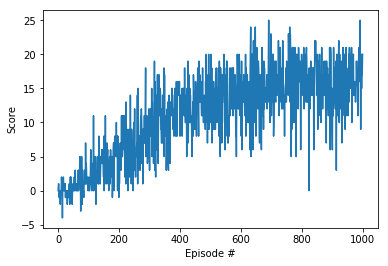

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_duel)), scores_duel)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [15]:
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_dueling.pth')

## 5. Observe the agent playing

In [12]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_dueling.pth'))

# watch an untrained agent
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 18.0


In [13]:
env.close()

## 6. Future work

Future improvements might include algorithmic improvements such as

1. Prioritized experience replay (see [https://arxiv.org/pdf/1511.05952.pdf](https://arxiv.org/pdf/1511.05952.pdf))
2. Rainbow algorithm or parts of it (see https://arxiv.org/pdf/1710.02298.pdf)

and trying different network architectures such as 

1. Batch Normalization layers
2. Dropout layers